In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
pd.options.display.max_columns=None

In [4]:
!pip install catboost

In [6]:
from catboost import CatBoostClassifier


In [7]:
!pip install dython


In [8]:
from dython.nominal import associations, identify_nominal_columns


In [9]:
raw = pd.read_csv('BankChurners.csv')


In [10]:
raw.sample(5)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
7273,713512308,Attrited Customer,50,F,0,Graduate,Single,Less than $40K,Blue,41,2,3,1,3423.0,0,3423.0,0.505,2229,45,0.406,0.000,0.989370,0.01063
913,783387783,Existing Customer,55,M,2,Uneducated,Divorced,$60K - $80K,Blue,49,4,5,3,10127.0,1873,8254.0,0.573,1647,53,0.472,0.185,0.000347,0.99965
7074,713058858,Attrited Customer,54,F,2,Graduate,Unknown,Less than $40K,Blue,46,5,3,2,1695.0,913,782.0,0.449,2130,48,0.500,0.539,0.994470,0.00553
4338,820633833,Existing Customer,64,F,1,Graduate,Single,$40K - $60K,Blue,56,5,2,4,5152.0,948,4204.0,0.953,4074,72,1.057,0.184,0.000307,0.99969
483,719451483,Existing Customer,46,F,4,Post-Graduate,Married,Less than $40K,Blue,37,5,3,2,3773.0,1972,1801.0,0.783,1528,25,1.083,0.523,0.000222,0.99978


In [11]:
raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [12]:
#Remove duplicates
raw.duplicated().sum()
raw['CLIENTNUM'].duplicated().sum()


0

In [13]:
#Drop useless features
raw.sample(3)
useless = ['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
           'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
dfDrop = raw.drop(useless, axis=1)
dfDrop.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [14]:
#Univariat analysis
dfDrop.describe().T


,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127.0,46.325960,8.016814,26.0,41.000,46.000,52.000,73.000
Dependent_count,10127.0,2.346203,1.298908,0.0,1.000,2.000,3.000,5.000
Months_on_book,10127.0,35.928409,7.986416,13.0,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.0,3.812580,1.554408,1.0,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.0,2.341167,1.010622,0.0,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.0,2.455317,1.106225,0.0,2.000,2.000,3.000,6.000
Credit_Limit,10127.0,8631.953698,9088.776650,1438.3,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.0,1162.814061,814.987335,0.0,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.0,7469.139637,9090.685324,3.0,1324.500,3474.000,9859.000,34516.000
Total_Amt_Chng_Q4_Q1,10127.0,0.759941,0.219207,0.0,0.631,0.736,0.859,3.397


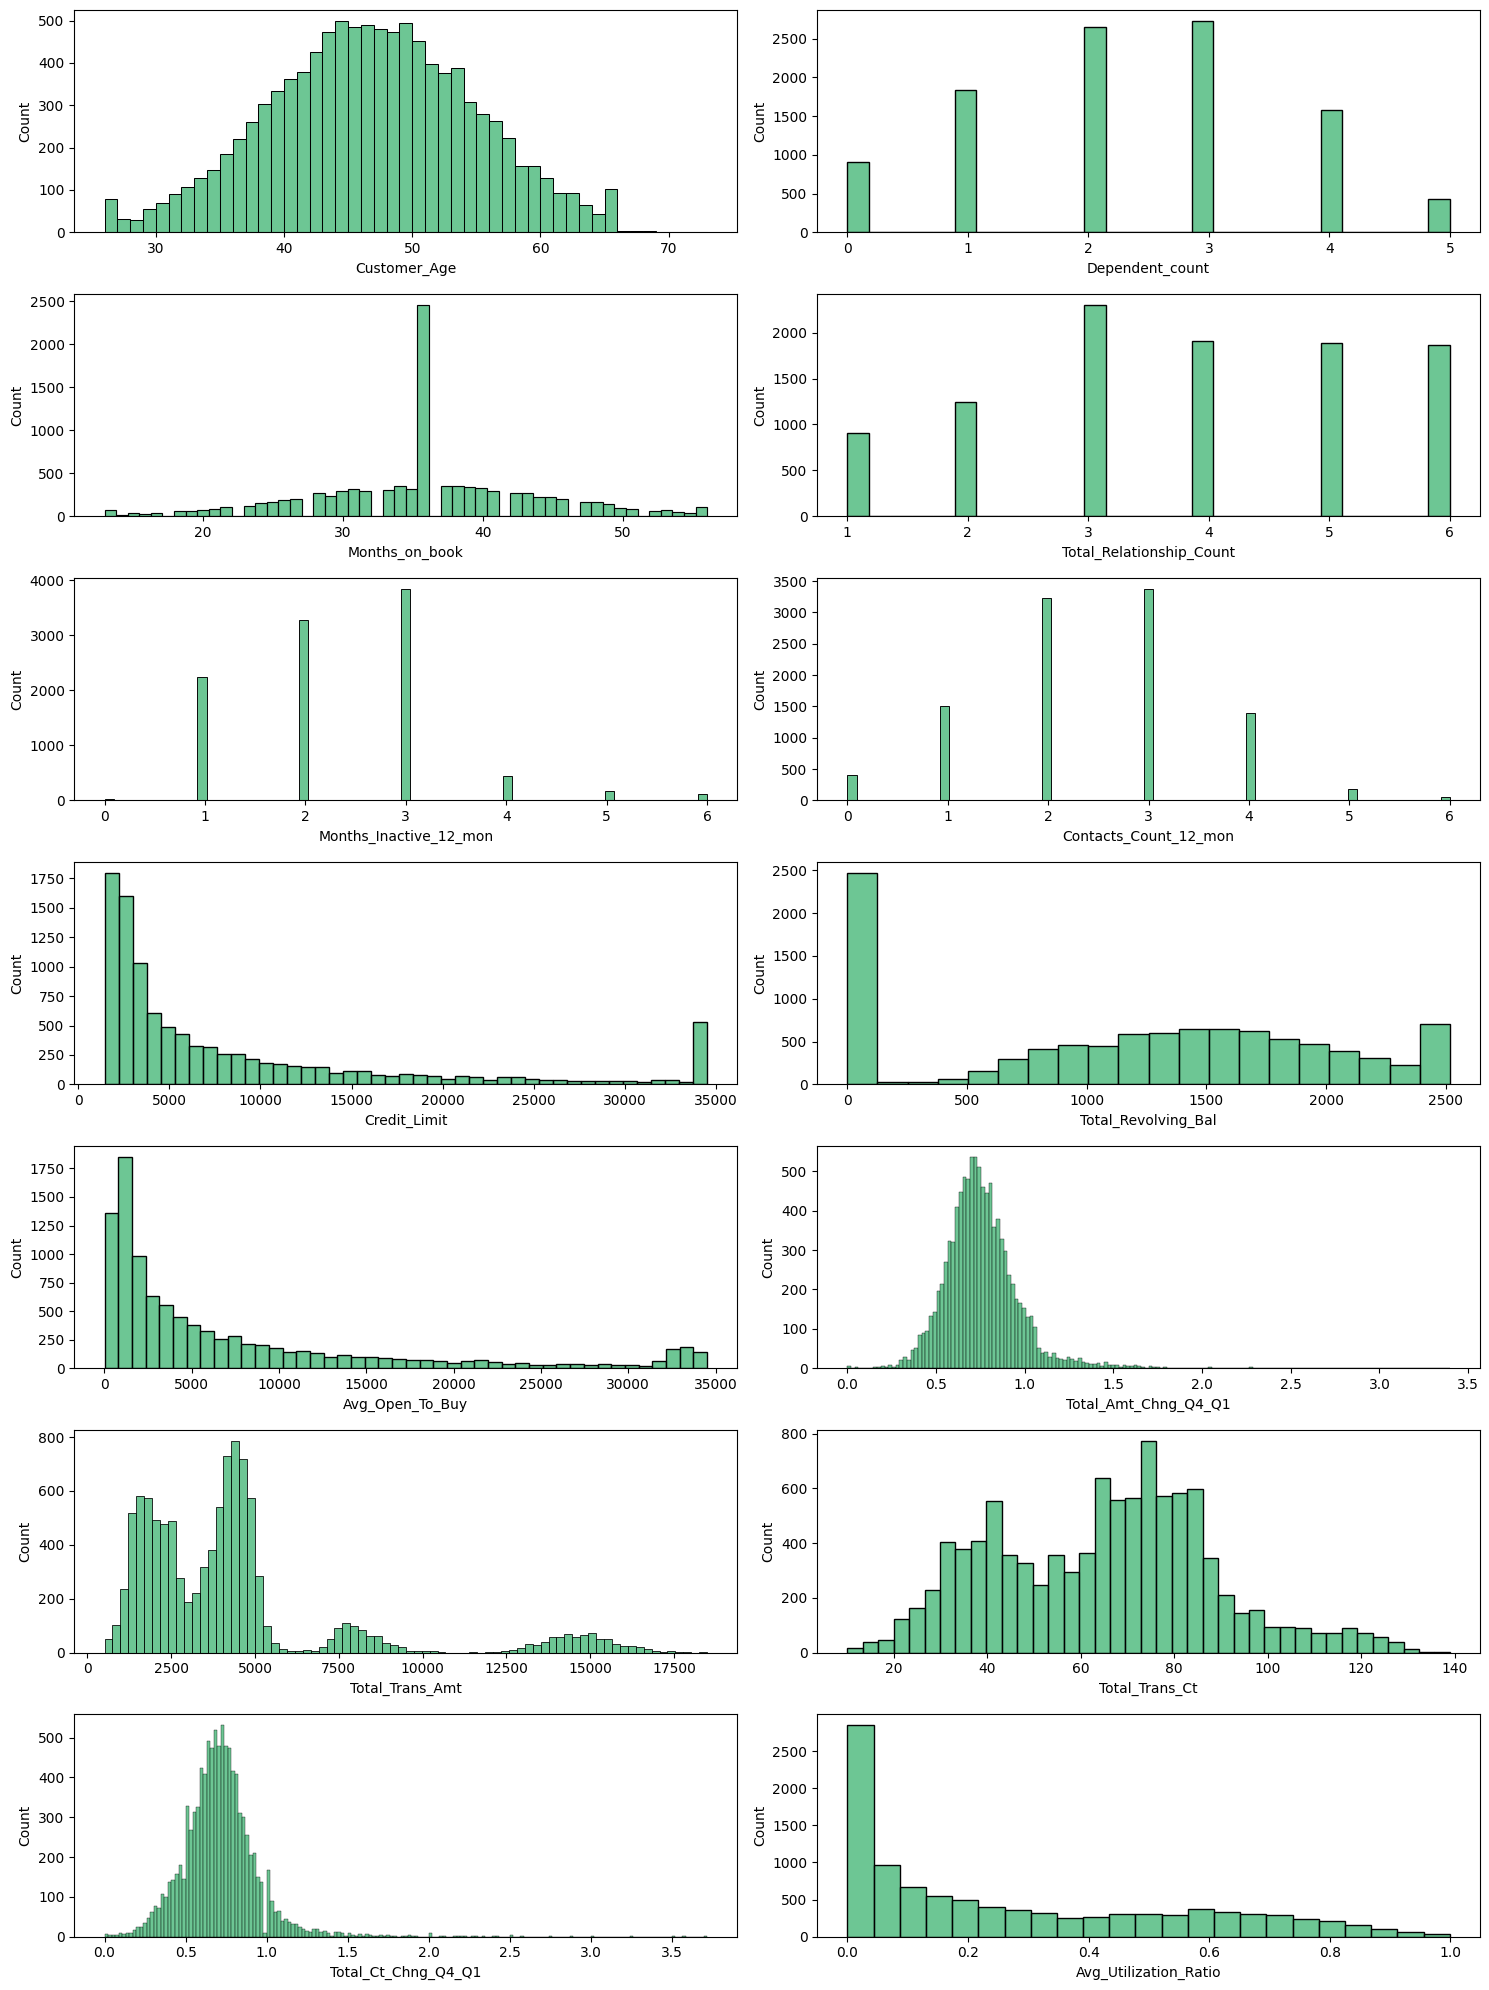

In [15]:
num = list(dfDrop.describe().columns)
plt.figure(figsize=(15, 20))
for i in range(0, len(num)):
    plt.subplot(7, 2, i+1)
    sns.histplot(x=dfDrop[num[i]], color='mediumseagreen')
    plt.xlabel(num[i])
    plt.tight_layout()

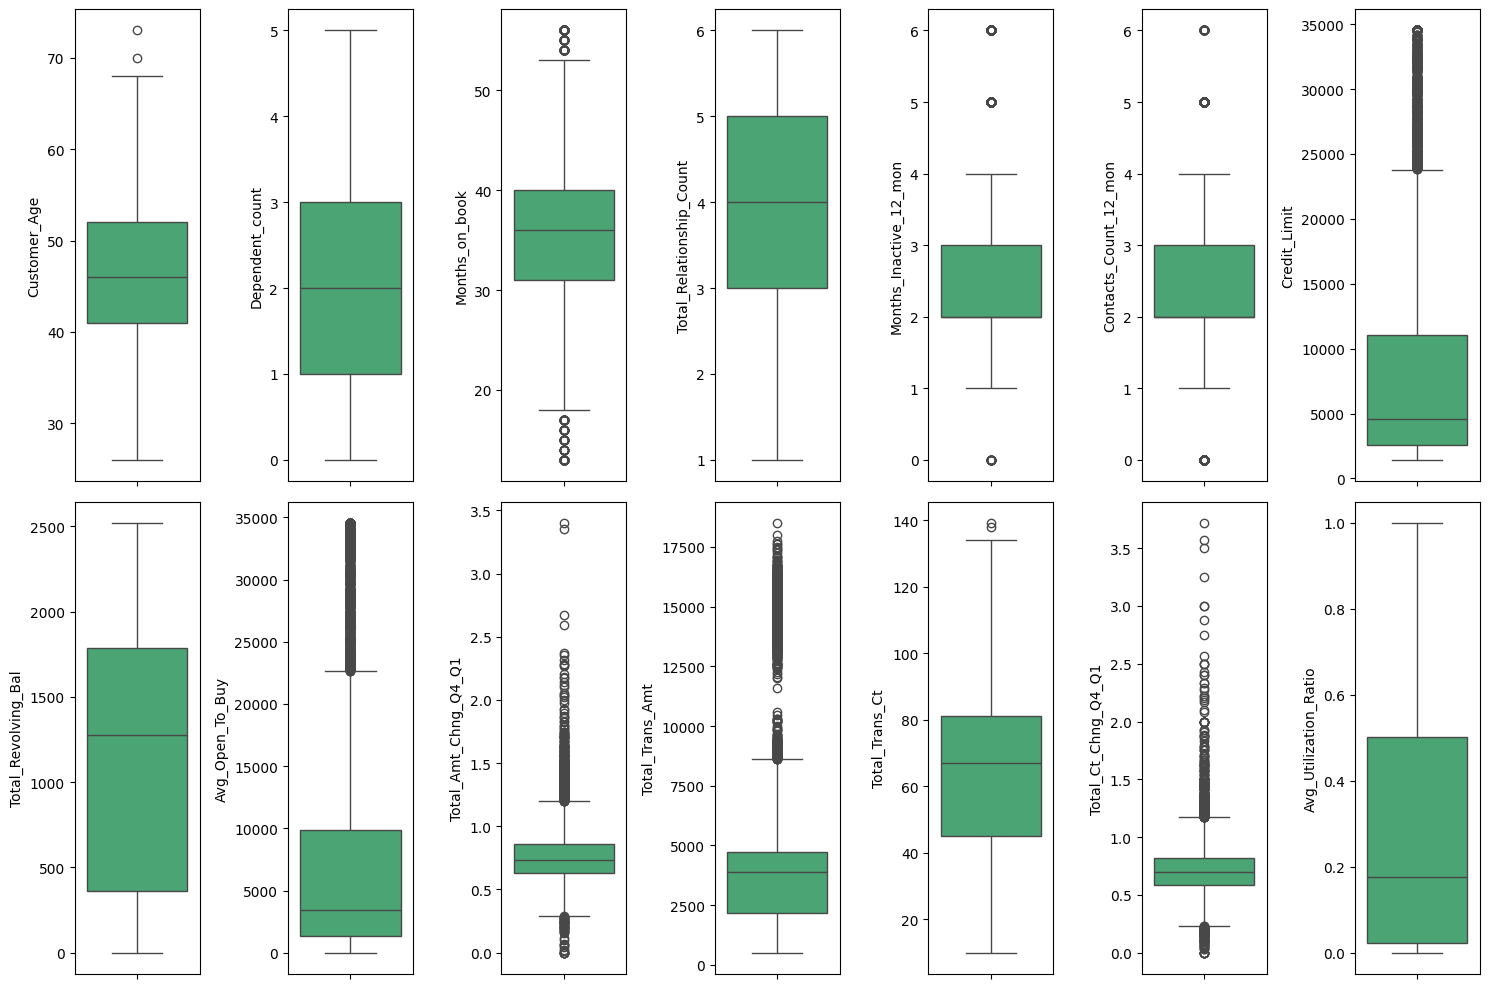

In [16]:
num = list(dfDrop.describe().columns)
plt.figure(figsize=(15,10))
for i in range(0, len(num)):
    plt.subplot(2, 7, i+1)
    sns.boxplot(y=dfDrop[num[i]], color='mediumseagreen', orient='v')
    plt.tight_layout()

In [17]:
dfDrop.describe(include='object').T

,count,unique,top,freq
Attrition_Flag,10127,2,Existing Customer,8500
Gender,10127,2,F,5358
Education_Level,10127,7,Graduate,3128
Marital_Status,10127,4,Married,4687
Income_Category,10127,6,Less than $40K,3561
Card_Category,10127,4,Blue,9436


In [18]:
cat = list(dfDrop.describe(include='object').columns)
for i in cat:
    print(dfDrop[i].value_counts())

Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64
Gender
F    5358
M    4769
Name: count, dtype: int64
Education_Level
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: count, dtype: int64
Marital_Status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64
Income_Category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: count, dtype: int64
Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: count, dtype: int64


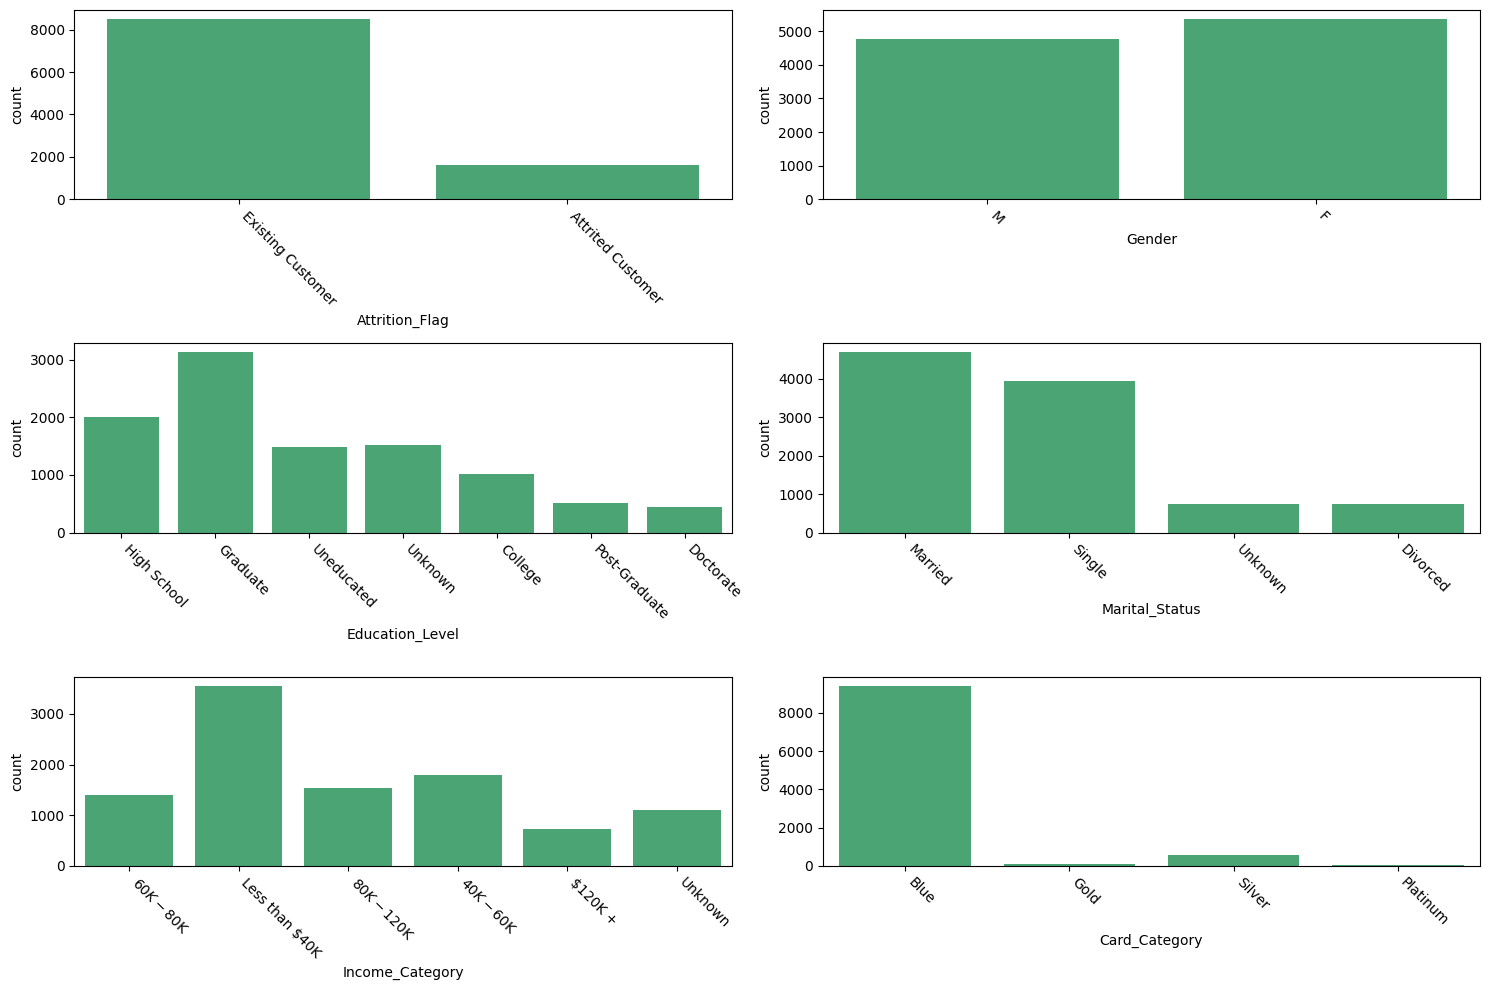

In [19]:
cat = list(dfDrop.describe(include='object').columns)
plt.figure(figsize=(15,10))
for i in range(0, len(cat)):
    plt.subplot(3, 2, i+1)
    sns.countplot(x = dfDrop[cat[i]], color='mediumseagreen', orient='v')
    plt.xticks(rotation=-45, ha='left')
    plt.tight_layout()

In [20]:
eda1 = dfDrop.groupby('Income_Category').agg({'Attrition_Flag':'count'}).reset_index()
eda1.columns = ['Income','Customer']
eda1['Ratio'] = round((eda1['Customer']/eda1['Customer'].sum())*100,2)
eda1

,Income,Customer,Ratio
0,$120K +,727,7.18
1,$40K - $60K,1790,17.68
2,$60K - $80K,1402,13.84
3,$80K - $120K,1535,15.16
4,Less than $40K,3561,35.16
5,Unknown,1112,10.98


In [21]:
eda1.loc[0,'Income'] = '120K +'
eda1.loc[1,'Income'] = '40K - 60K'
eda1.loc[2,'Income'] = '60K - 80K'
eda1.loc[3,'Income'] = '80K - 120K'
eda1.loc[4,'Income'] = 'Less than 40K'
eda1.loc[5,'Income'] = 'Unknown'
eda1 = eda1.sort_values('Ratio', ascending=False).reindex([5,4,1,2,3,0]).reset_index(drop=True)
eda1

,Income,Customer,Ratio
0,Unknown,1112,10.98
1,Less than 40K,3561,35.16
2,40K - 60K,1790,17.68
3,60K - 80K,1402,13.84
4,80K - 120K,1535,15.16
5,120K +,727,7.18


Text(0.5, 1.0, 'Distribution of Customer Income')

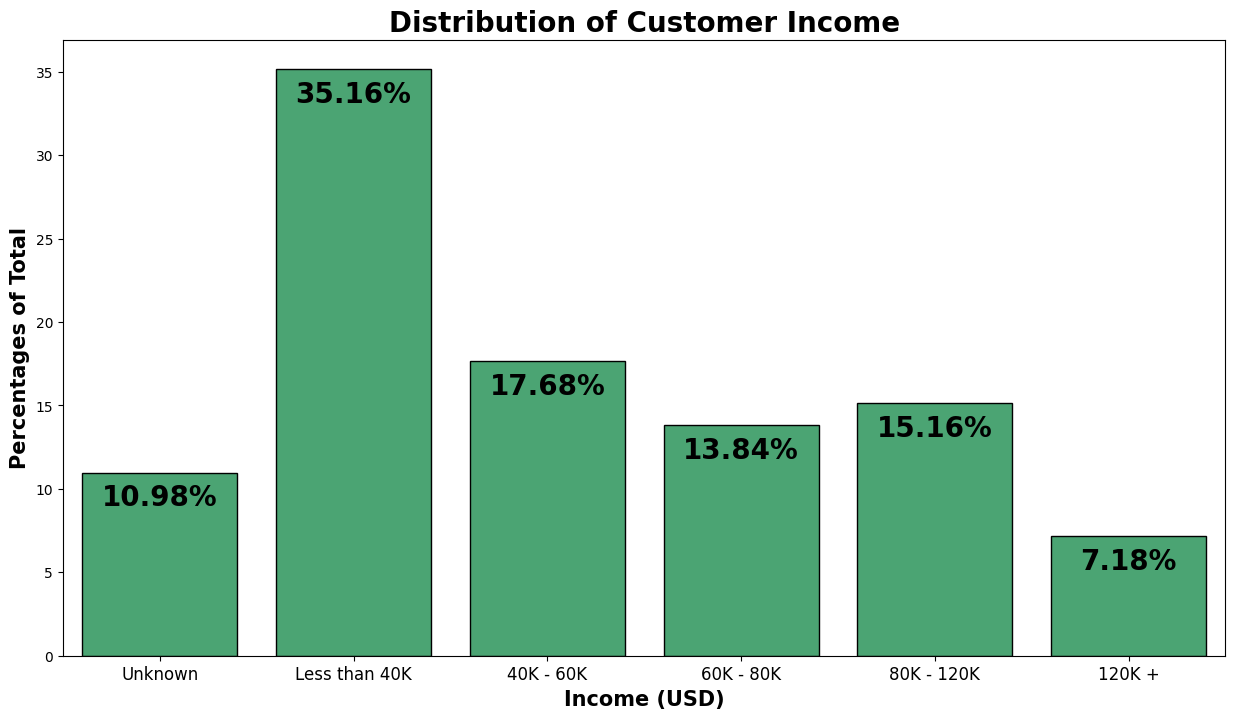

In [22]:
plt.figure(figsize = (15,8))
sns.barplot(data = eda1, x='Income', y='Ratio', color='mediumseagreen', edgecolor='black')
plt.xlabel('Income (USD)', size=15, weight='bold')
plt.xticks(size=12)
plt.ylabel('Percentages of Total', size=15, weight='bold')
for i in range(len(eda1)):
    plt.text(x=i, y=eda1.loc[i, 'Ratio'] - 2, s=str(eda1.loc[i,'Ratio']) + '%', ha='center', size=20, weight='bold')
plt.title('Distribution of Customer Income', size=20, weight='bold')

In [23]:
eda2 = dfDrop.groupby('Education_Level').agg({'Attrition_Flag':'count'}).reset_index()
eda2.columns = ['Education_Level','Customer']
eda2['Ratio'] = round((eda2['Customer']/eda2['Customer'].sum())*100,2)
eda2 = eda2.sort_values('Ratio', ascending=False).reindex([6,5,3,0,2,4,1]).reset_index(drop=True)
eda2

,Education_Level,Customer,Ratio
0,Unknown,1519,15.00
1,Uneducated,1487,14.68
2,High School,2013,19.88
3,College,1013,10.00
4,Graduate,3128,30.89
5,Post-Graduate,516,5.10
6,Doctorate,451,4.45


Text(0.5, 1.0, 'Education Level')

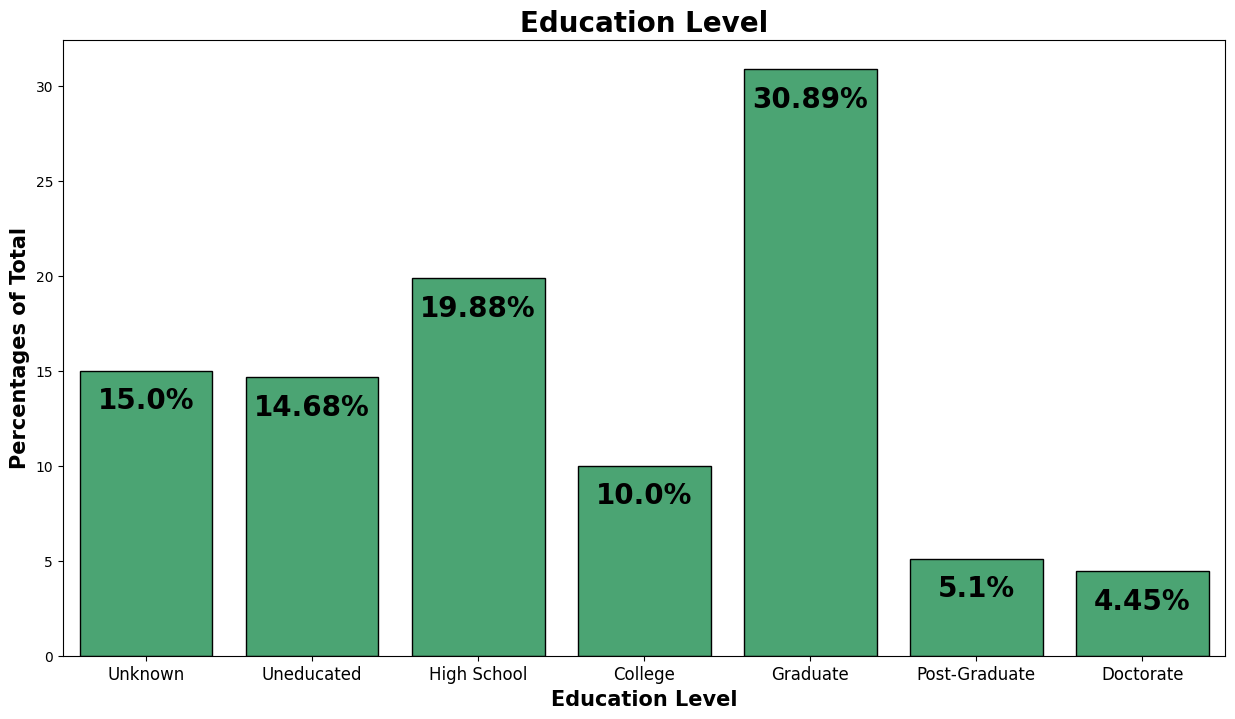

In [24]:
plt.figure(figsize = (15,8))
sns.barplot(data = eda2, x='Education_Level', y='Ratio', color='mediumseagreen', edgecolor='black')
plt.xlabel('Education Level', size=15, weight='bold')
plt.xticks(size=12)
plt.ylabel('Percentages of Total', size=15, weight='bold')
for i in range(len(eda2)):
    plt.text(x=i, y=eda2.loc[i, 'Ratio'] - 2, s=str(eda2.loc[i,'Ratio']) + '%', ha='center', size=20, weight='bold')
plt.title('Education Level', size=20, weight='bold')

<ipython-input-25-170fd3096b47>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=dfDrop[num[i]], orient='v', x=dfDrop['Attrition_Flag'], palette="Set2")
<ipython-input-25-170fd3096b47>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=dfDrop[num[i]], orient='v', x=dfDrop['Attrition_Flag'], palette="Set2")
<ipython-input-25-170fd3096b47>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=dfDrop[num[i]], orient='v', x=dfDrop['Attrition_Flag'], palette="Set2")
<ipython-input-25-170fd3096b47>:5: FutureWarning: 

Passing `palette` without assi

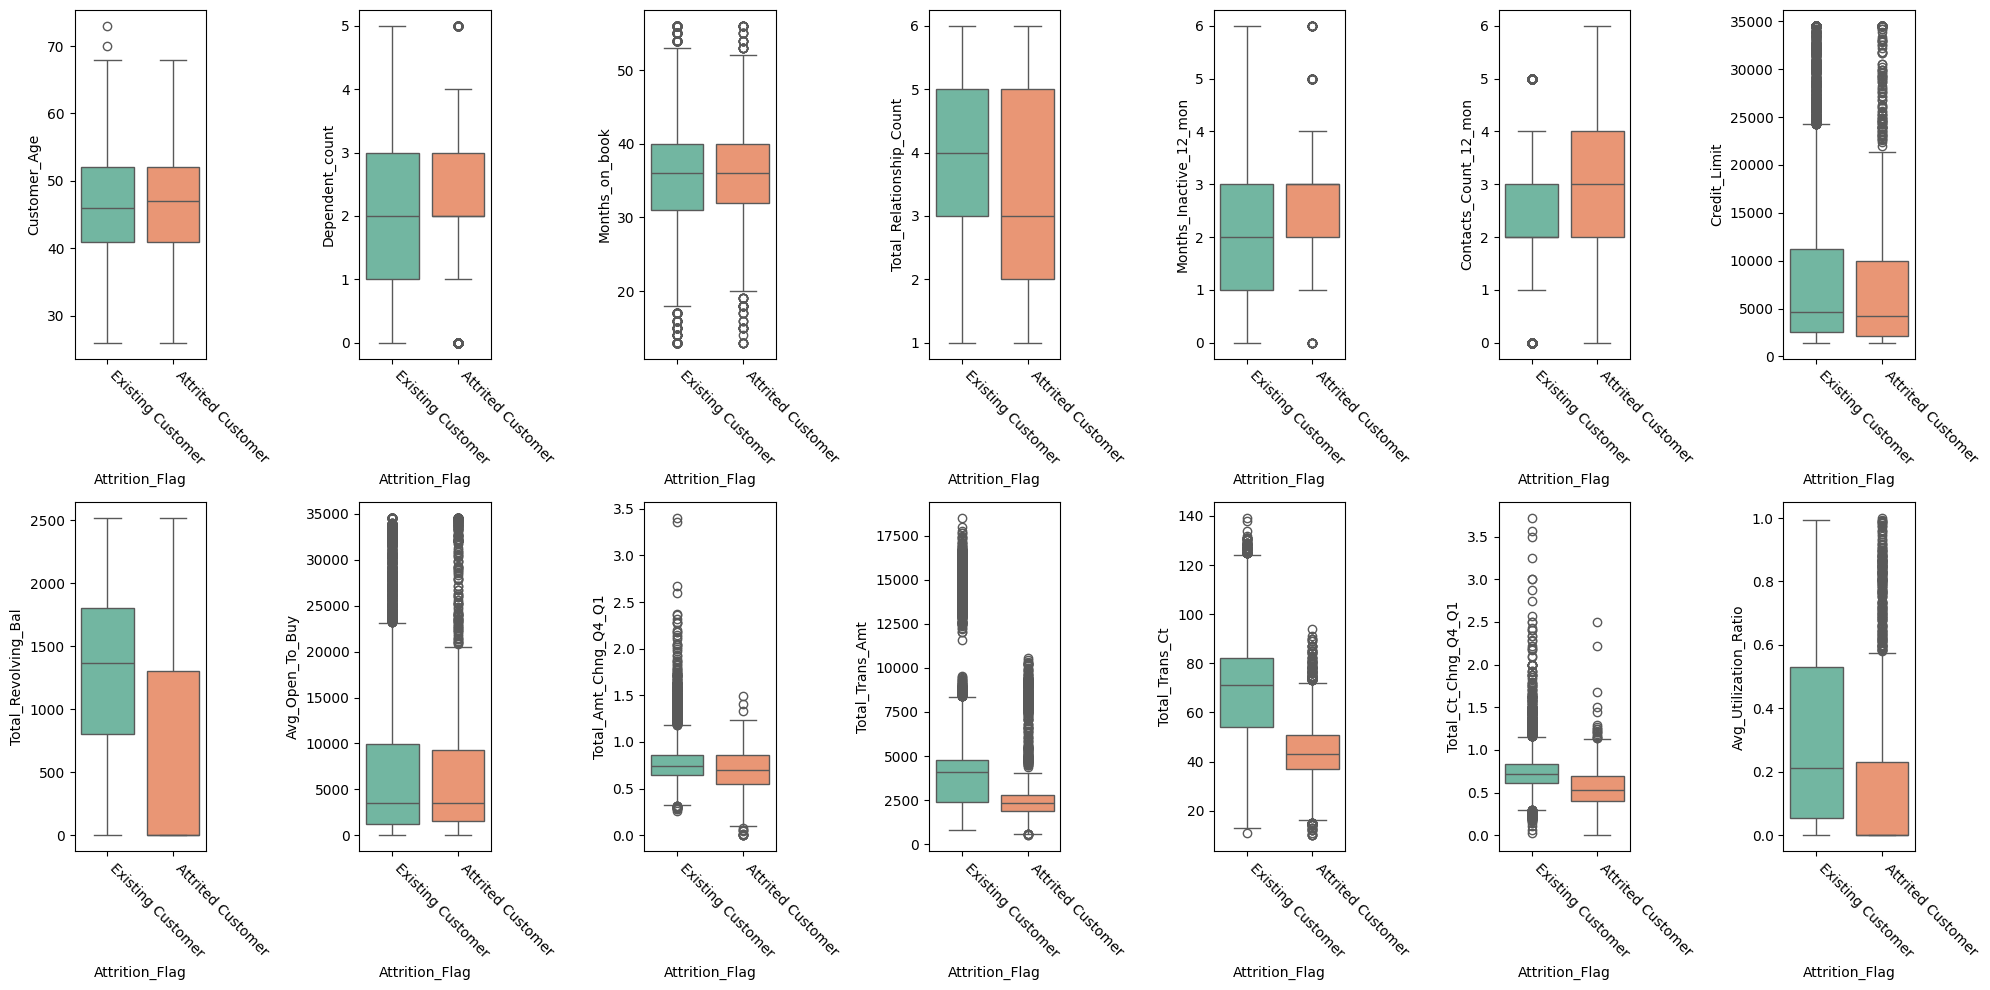

In [25]:
num = list(dfDrop.describe().columns)
plt.figure(figsize=(20,10))
for i in range(0, len(num)):
    plt.subplot(2, 7, i+1)
    sns.boxplot(y=dfDrop[num[i]], orient='v', x=dfDrop['Attrition_Flag'], palette="Set2")
    plt.xticks(rotation=-45, ha='left')
    plt.tight_layout()

<ipython-input-26-cf9845db981f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dfDrop, x='Total_Trans_Ct', y='Attrition_Flag', orient='h', palette='Set2')


Text(0.5, 1.0, 'Attrited customers have lower transaction count in the past 12 months')

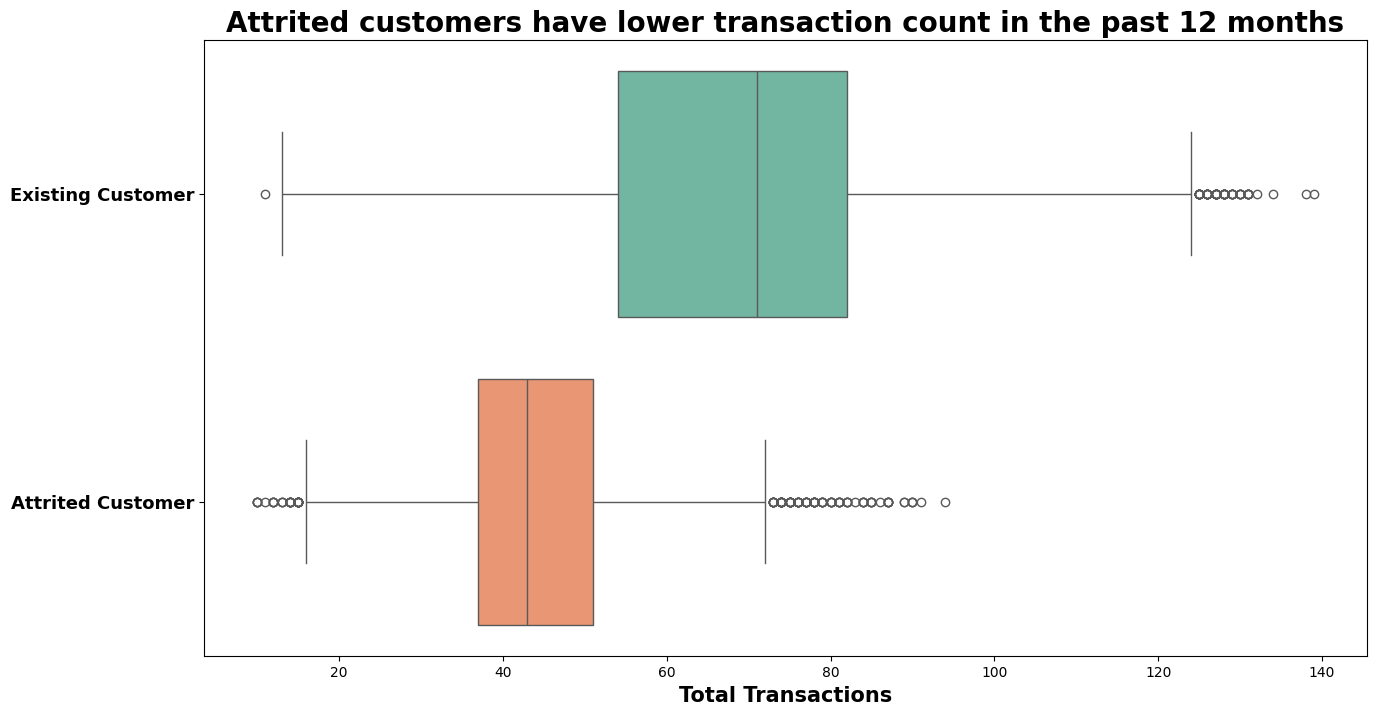

In [26]:
plt.figure(figsize=(15,8))
sns.boxplot(data=dfDrop, x='Total_Trans_Ct', y='Attrition_Flag', orient='h', palette='Set2')
plt.xlabel('Total Transactions', size=15, weight='bold')
plt.ylabel('', size=15, weight='bold')
plt.yticks(size=13, weight='bold')
plt.title('Attrited customers have lower transaction count in the past 12 months', size=20, weight='bold')

Text(0.5, 1.0, 'Transaction Count vs Transaction Amount')

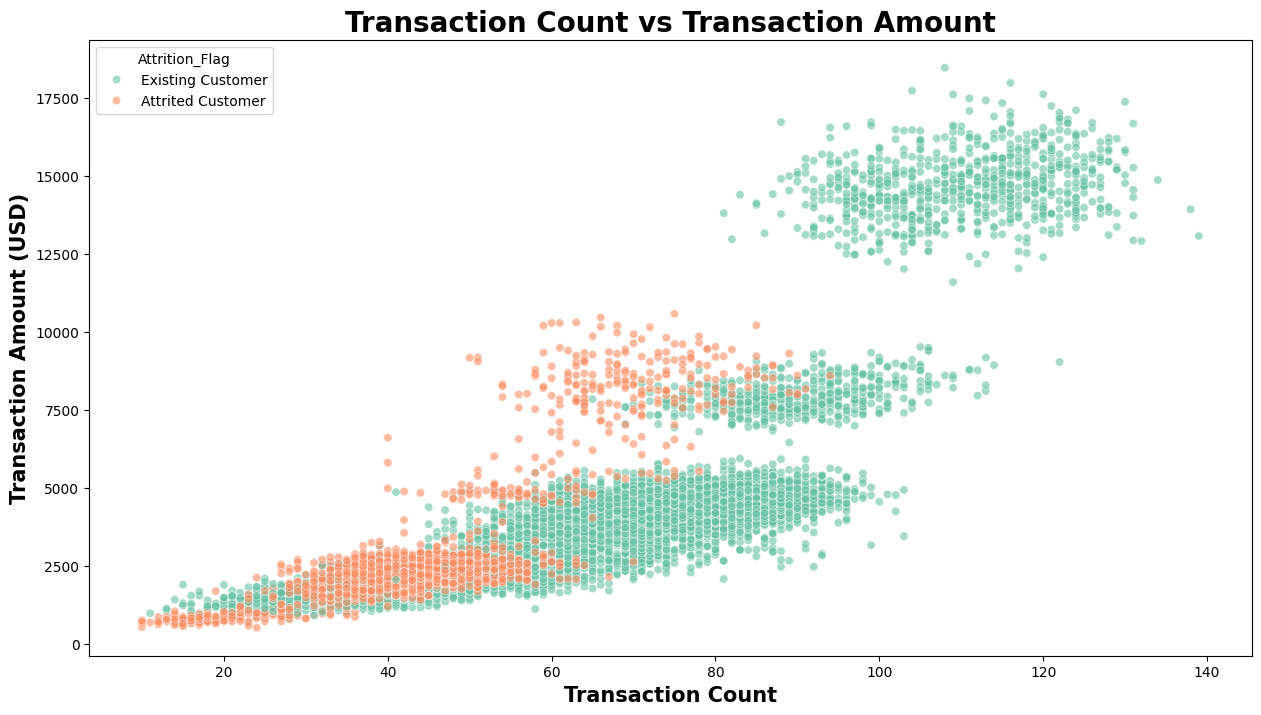

In [27]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=dfDrop, x='Total_Trans_Ct', y='Total_Trans_Amt', hue='Attrition_Flag', alpha=0.6, palette='Set2')
plt.xlabel('Transaction Count', size=15, weight='bold')
plt.ylabel('Transaction Amount (USD)', size=15, weight='bold')
plt.title('Transaction Count vs Transaction Amount', size=20, weight='bold')

In [79]:
#CLICK ON THE BOXES FOR DIFFERENT VISUALIZATION
import plotly.express as px
import pandas as pd
import plotly.graph_objs as go

# Assuming dfDrop is your DataFrame containing numerical columns
num_columns = list(dfDrop.describe().columns)

# Create a figure with subplots
fig = go.Figure()

# Loop through numerical columns
for i, col in enumerate(num_columns):
    # Create KDE plot for each numerical column
    fig.add_trace(
        go.Histogram(
            x=dfDrop[col][dfDrop['Attrition_Flag'] == 'Existing Customer'],
            histnorm='percent',
            name='Existing Customer',
            marker_color='rgba(0, 123, 255, 0.6)'
        )
    )

    fig.add_trace(
        go.Histogram(
            x=dfDrop[col][dfDrop['Attrition_Flag'] == 'Attrited Customer'],
            histnorm='percent',
            name='Attrited Customer',
            marker_color='rgba(255, 153, 51, 0.6)'
        )
    )

    # Update layout for each subplot
    fig.update_layout(
        title=f'KDE Plot of {col} by Attrition_Flag',
        xaxis_title=col,
        yaxis_title='Percentage',
        showlegend=True
    )

# Show the plot
fig.show()


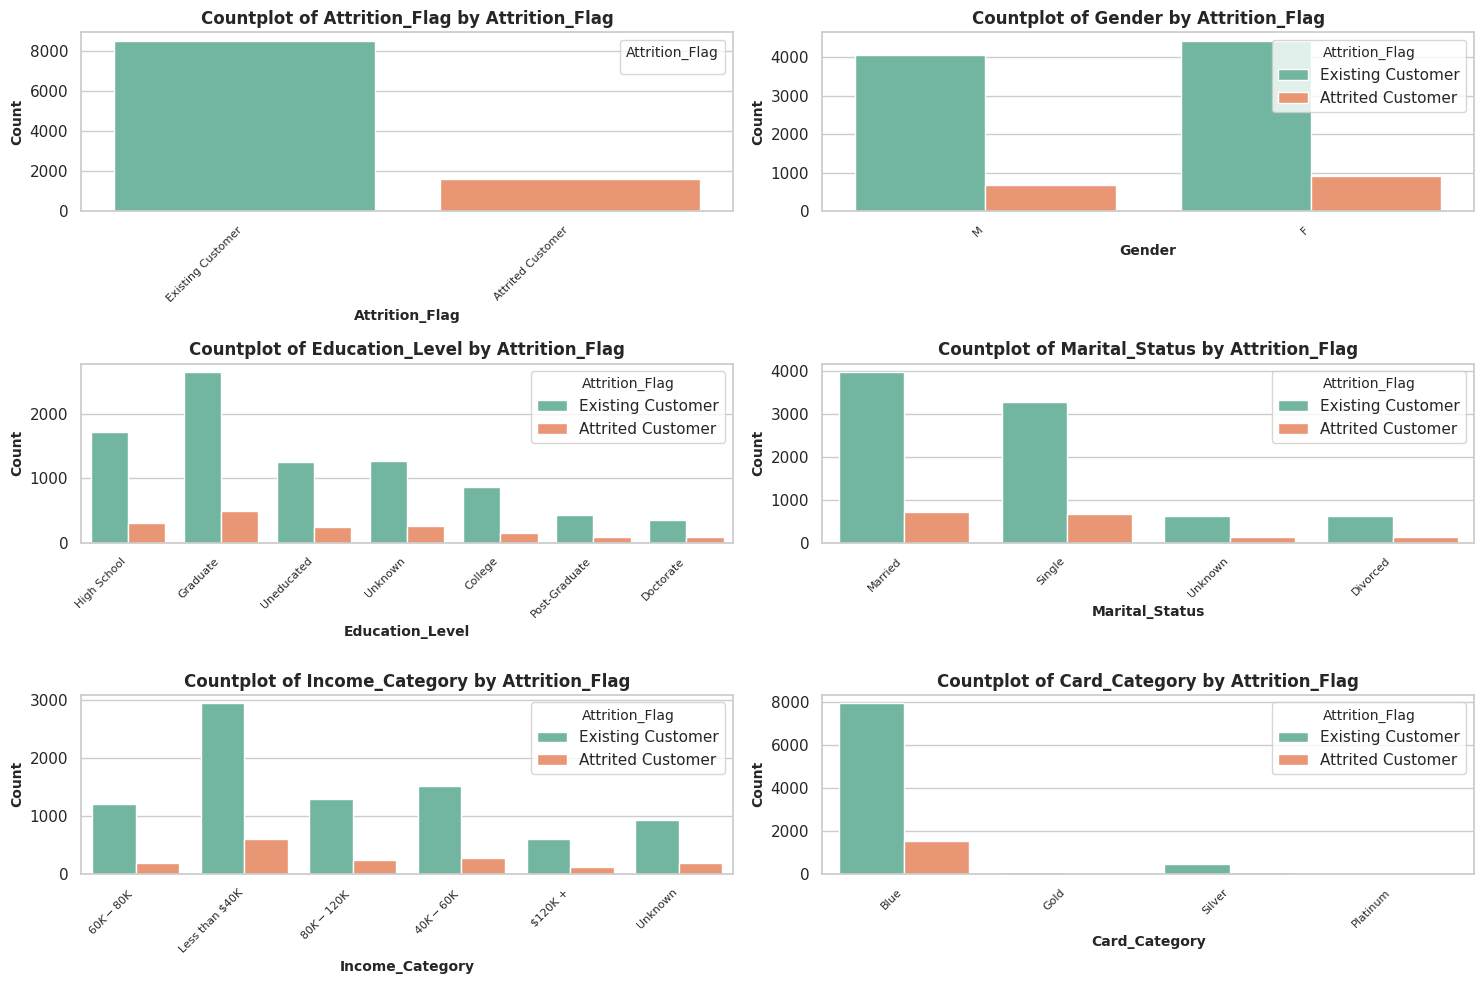

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of categorical columns
cat_columns = list(dfDrop.describe(include='object').columns)

# Set up the plot
plt.figure(figsize=(15, 10))

# Define a custom color palette with more distinct colors
custom_palette = sns.color_palette('Set2', n_colors=len(dfDrop[cat_columns[0]].unique()))

# Iterate over categorical columns
for i, col in enumerate(cat_columns):
    plt.subplot(3, 2, i+1)
    sns.countplot(x=dfDrop[col], hue=dfDrop['Attrition_Flag'], palette=custom_palette, orient='v')
    plt.title(f'Countplot of {col} by Attrition_Flag', size=12, weight='bold')
    plt.xlabel(col, size=10, weight='bold')
    plt.ylabel('Count', size=10, weight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.legend(title='Attrition_Flag', title_fontsize='10')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


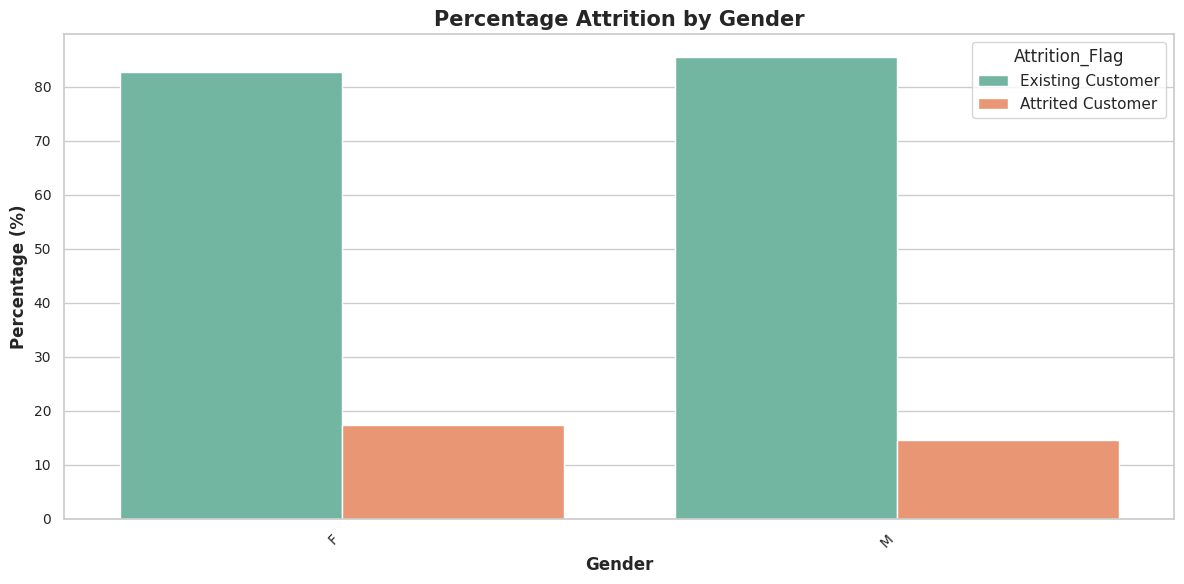

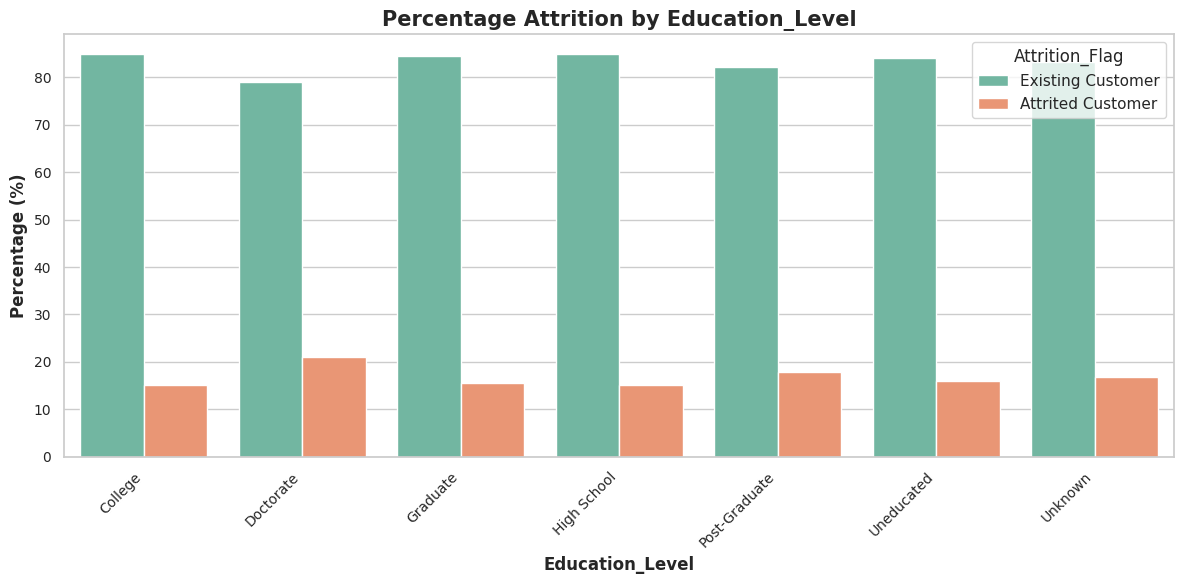

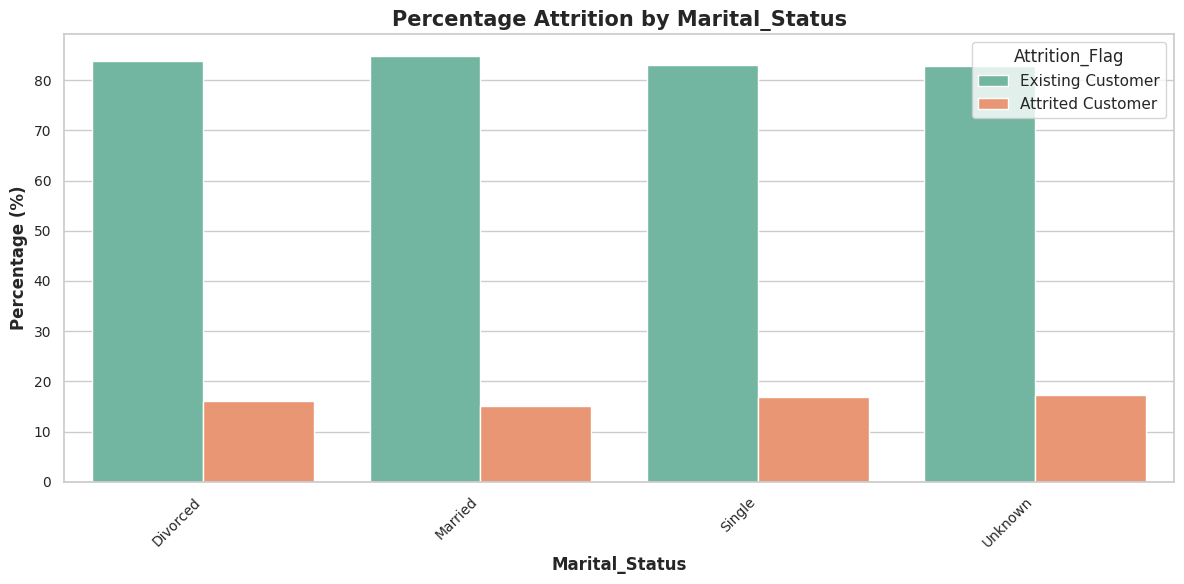

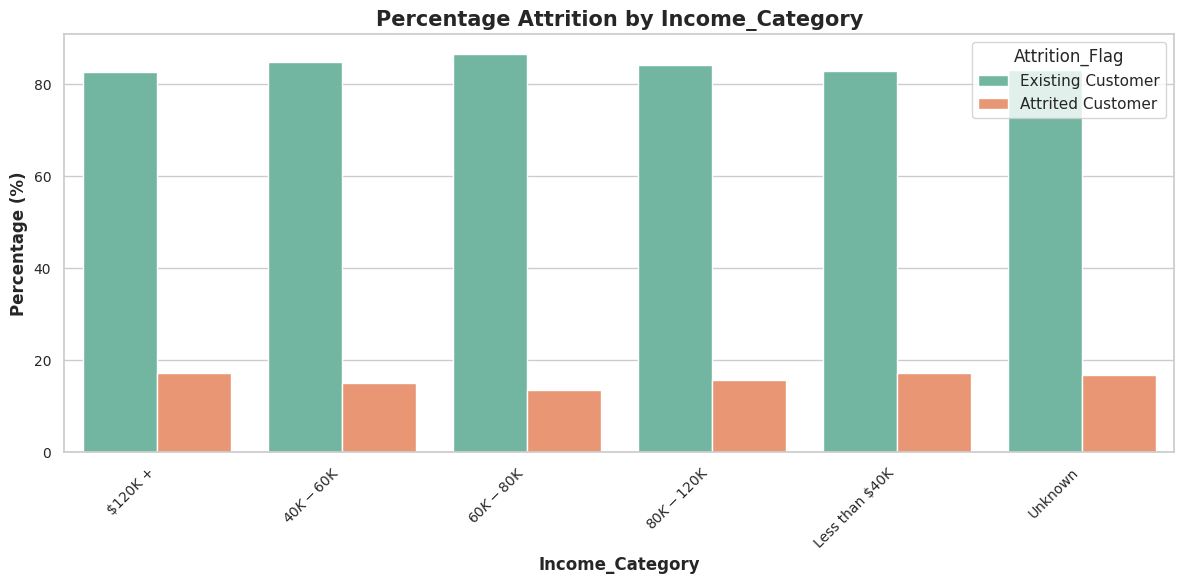

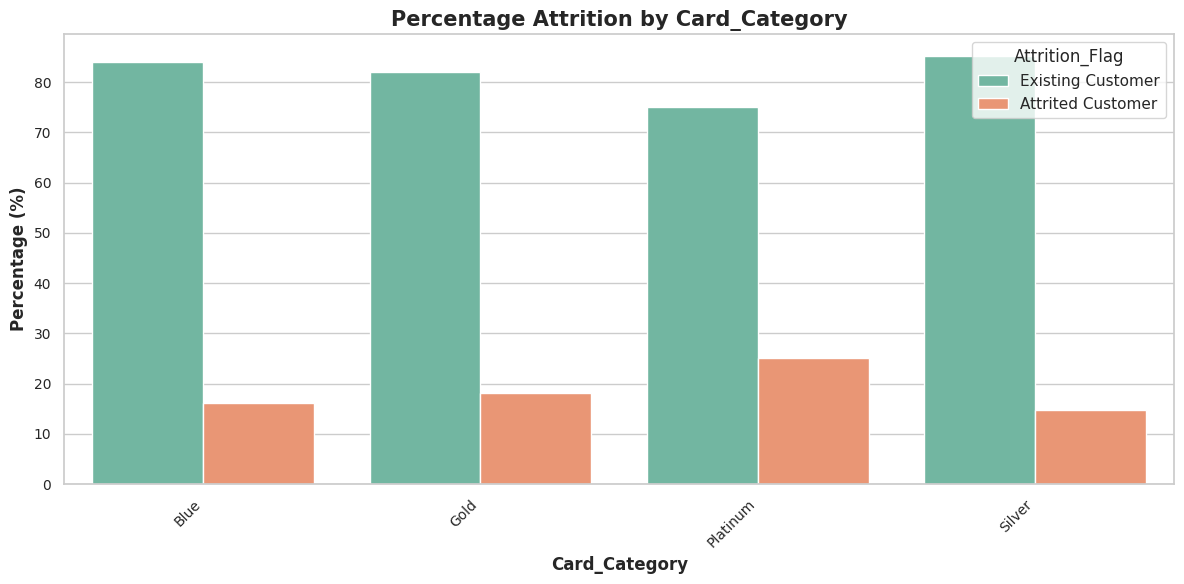

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of categorical columns
cat_columns = list(dfDrop.describe(include='object'))
cat_columns.remove('Attrition_Flag')

# Counter for subplot positioning
subplot_idx = 1

# Iterate over categorical columns
for col in cat_columns:
    # Calculate percentages
    cat_percent = (dfDrop.groupby(col)['Attrition_Flag']
                   .value_counts(normalize=True)
                   .mul(100)
                   .rename('percent')
                   .reset_index())

    # Plot with seaborn using Set2 palette
    plt.figure(figsize=(12, 6))
    sns.barplot(data=cat_percent, x=col, y='percent', hue='Attrition_Flag', palette='Set2')

    # Adjust aesthetics
    plt.title(f'Percentage Attrition by {col}', size=15, weight='bold')
    plt.xlabel(col, size=12, weight='bold')
    plt.ylabel('Percentage (%)', size=12, weight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Attrition_Flag', title_fontsize='12')

    # Show plot
    plt.tight_layout()
    plt.show()


In [31]:
dfDrop.sample(1)


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
9375,Attrited Customer,54,M,1,Post-Graduate,Unknown,$80K - $120K,Blue,36,1,3,2,18512.0,1664,16848.0,0.889,8019,57,0.583,0.09


In [32]:
eda3 = dfDrop.groupby(['Card_Category','Attrition_Flag']).agg({'Customer_Age':'count'}).reset_index()
eda3.columns = ['Card_Category','Attrition_Flag','Customer']
eda3

,Card_Category,Attrition_Flag,Customer
0,Blue,Attrited Customer,1519
1,Blue,Existing Customer,7917
2,Gold,Attrited Customer,21
3,Gold,Existing Customer,95
4,Platinum,Attrited Customer,5
5,Platinum,Existing Customer,15
6,Silver,Attrited Customer,82
7,Silver,Existing Customer,473


In [33]:
eda3card = eda3.groupby('Card_Category').sum('Customer').reset_index()
eda3card.columns = ['Card_Category','Total Customer']

In [34]:
eda3final = eda3.merge(eda3card, how='inner', on='Card_Category')
eda3final['Ratio'] = round(eda3final['Customer']/eda3final['Total Customer']*100,2)
eda3final

,Card_Category,Attrition_Flag,Customer,Total Customer,Ratio
0,Blue,Attrited Customer,1519,9436,16.10
1,Blue,Existing Customer,7917,9436,83.90
2,Gold,Attrited Customer,21,116,18.10
3,Gold,Existing Customer,95,116,81.90
4,Platinum,Attrited Customer,5,20,25.00
5,Platinum,Existing Customer,15,20,75.00
6,Silver,Attrited Customer,82,555,14.77
7,Silver,Existing Customer,473,555,85.23


In [35]:
attCust = eda3final[eda3final['Attrition_Flag']=='Attrited Customer'].reindex([0,6,2,4]).reset_index(drop=True)
attCust

,Card_Category,Attrition_Flag,Customer,Total Customer,Ratio
0,Blue,Attrited Customer,1519,9436,16.10
1,Silver,Attrited Customer,82,555,14.77
2,Gold,Attrited Customer,21,116,18.10
3,Platinum,Attrited Customer,5,20,25.00


In [36]:
existCust = eda3final[eda3final['Attrition_Flag']=='Existing Customer'].reindex([1,7,3,5])
existCust

,Card_Category,Attrition_Flag,Customer,Total Customer,Ratio
1,Blue,Existing Customer,7917,9436,83.90
7,Silver,Existing Customer,473,555,85.23
3,Gold,Existing Customer,95,116,81.90
5,Platinum,Existing Customer,15,20,75.00


In [73]:
import plotly.graph_objs as go

# Assuming attCust and existCust are your DataFrames or arrays holding the data

# Create traces for each bar
trace1 = go.Bar(
    x=attCust['Card_Category'],
    y=attCust['Ratio'],
    name='Attrited Customer',
    marker=dict(color='orangered', line=dict(color='black', width=1))
)

trace2 = go.Bar(
    x=existCust['Card_Category'],
    y=existCust['Ratio'],
    name='Existing Customer',
    marker=dict(color='grey', line=dict(color='black', width=1))
)

# Define layout
layout = go.Layout(
    title='Platinum customer have high percentages of attrited customer',
    xaxis=dict(title='Card Category', tickfont=dict(size=12)),
    yaxis=dict(title='Percentages of Total Customer (%)', tickfont=dict(size=12)),
    barmode='stack'
)

# Create figure object and add traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Add text annotations
for i in range(len(attCust)):
    fig.add_annotation(
        x=attCust.loc[i, 'Card_Category'],
        y=attCust.loc[i, 'Ratio'] / 2,
        text=f"{attCust.loc[i, 'Ratio']}%",
        showarrow=True,
        arrowhead=0,
        ax=0,
        ay=-40,
        font=dict(size=14, color='black')
    )

# Show the figure
fig.show()


In [71]:
import plotly.express as px

# Assuming eda3final is your DataFrame

# Create a bar plot using Plotly Express
fig = px.bar(eda3final, x='Card_Category', y='Ratio', color='Attrition_Flag',
             labels={'Card_Category': 'Card Category', 'Ratio': 'Ratio'},
             title='Ratio by Card Category and Attrition Flag',
             color_discrete_map={'0': '#1f77b4', '1': '#ff7f0e'})

# Customize layout
fig.update_layout(
    xaxis=dict(title='Card Category', tickfont_size=14),
    yaxis=dict(title='Ratio', tickfont_size=14),
    title_font_size=20,
    legend_title='Attrition Flag',
    legend_traceorder='reversed',
    legend=dict(title_font_size=15)
)

# Show the plot
fig.show()


<Figure size 1500x1500 with 0 Axes>

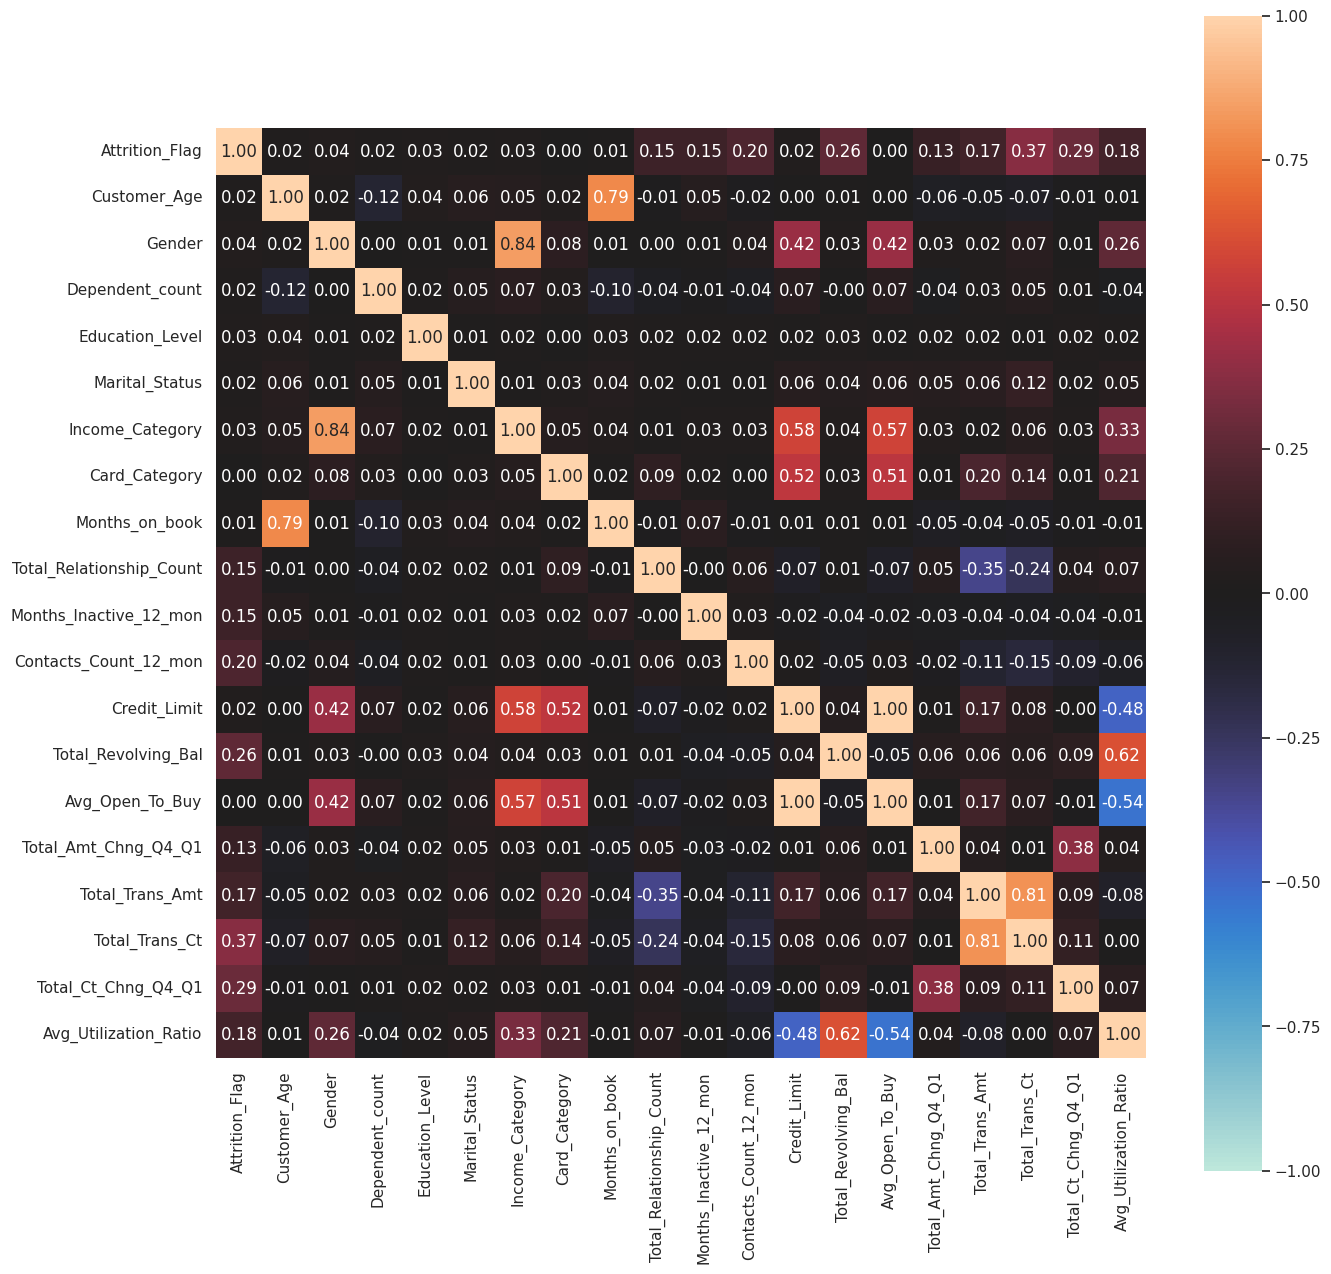

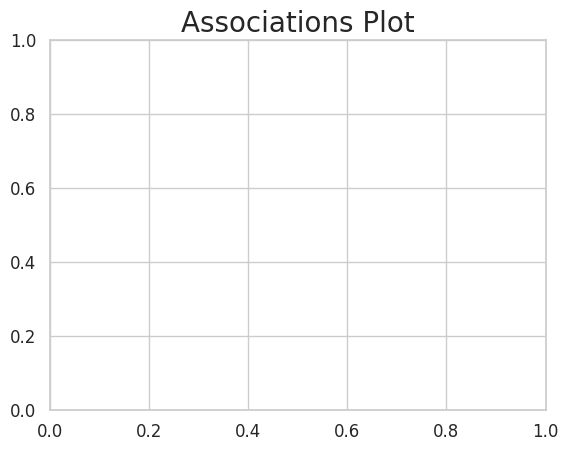

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations

# Assuming dfDrop is your DataFrame

# Set the style and figure size
plt.figure(figsize=(15, 15))
sns.set(style="whitegrid")  # Set the style here, e.g., "whitegrid", "darkgrid", "ticks", etc.

# Generate the associations plot
associations(dfDrop, figsize=(15,15), nan_strategy='drop_samples')

# Customize the plot further if needed
plt.title('Associations Plot', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.show()


In [41]:
#Missing Values
dfMissing = dfDrop.copy()
dfMissing.isna().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [42]:
#Label encoding
dfLabel = dfMissing.copy()
dfLabel.describe(include='object')

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,10127,10127,10127,10127,10127,10127
unique,2,2,7,4,6,4
top,Existing Customer,F,Graduate,Married,Less than $40K,Blue
freq,8500,5358,3128,4687,3561,9436


In [43]:
mapAttrition = {'Attrited Customer':1, 'Existing Customer':0}
mapGender = {'M':1, 'F':0}
mapCard = {'Blue':0, 'Silver':1, 'Gold':2, 'Platinum':3}

dfLabel['Attrition_Flag'] = dfLabel['Attrition_Flag'].map(mapAttrition)
dfLabel['Gender'] = dfLabel['Gender'].map(mapGender)
dfLabel['Card_Category'] = dfLabel['Card_Category'].map(mapCard)

dfLabel[['Attrition_Flag','Gender','Card_Category']].sample(5)

,Attrition_Flag,Gender,Card_Category
4944,0,0,0
8188,0,0,0
8496,1,0,0
1964,0,0,0
6416,0,0,0


In [44]:
#One-hot encoding
dfOHE = dfLabel.copy()
dfOHE.describe(include='object')

,Education_Level,Marital_Status,Income_Category
count,10127,10127,10127
unique,7,4,6
top,Graduate,Married,Less than $40K
freq,3128,4687,3561


In [45]:
cat = list(dfOHE.describe(include='object').columns)
for feature in cat:
    onehots = pd.get_dummies(dfOHE[feature], prefix=feature)
    dfOHE = dfOHE.join(onehots).drop(feature, axis=1)
dfOHE.sample(3)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown
5760,0,36,0,4,0,36,5,3,0,4228.0,1886,2342.0,1.076,4356,74,0.682,0.446,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False
1837,0,31,1,1,0,26,4,1,2,2037.0,0,2037.0,0.880,2563,64,0.641,0.000,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False
2363,0,31,1,0,0,21,6,2,2,2621.0,1461,1160.0,0.775,2718,71,0.775,0.557,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False


In [46]:
#Machine learning modelling
dfFinal = dfOHE.copy()
y = dfFinal.loc[:,'Attrition_Flag']
x = dfFinal.loc[:, dfFinal.columns!='Attrition_Flag']

In [47]:
#Train Test Split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size= 0.2, random_state=42, stratify=y)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((8101, 33), (2026, 33), (8101,), (2026,))

In [48]:
#Standardizing
sc = StandardScaler()
xtrain_sc = sc.fit_transform(xtrain)
xtest_sc = sc.transform(xtest)

In [49]:
#Oversampling
counter = Counter(ytrain)
print('Before', counter)

smt = SMOTE(sampling_strategy=0.5)
xtrain_scsm, ytrain_scsm = smt.fit_resample(xtrain_sc, ytrain)

counter = Counter(ytrain_scsm)
print('After', counter)

Before Counter({0: 6799, 1: 1302})
After Counter({0: 6799, 1: 3399})


In [53]:
#Fitting and Model Evaluation
%%time
logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
xg = XGBClassifier(use_label_encoder=False)
cb = CatBoostClassifier(random_state=42, silent=True)

model = [logreg, knn, dt, rf, xg, cb]
me_sum = pd.DataFrame({'model':[],'accuracytrain':[],'accuracytest':[],'precision':[],'recall':[],'rocauc':[]})

for i in model:
    i.fit(xtrain_scsm, ytrain_scsm)
    ytrainpredict = i.predict(xtrain_scsm)
    ytestpredict = i.predict(xtest_sc)
    accuracytrain = round(accuracy_score(ytrain_scsm, ytrainpredict),3)
    accuracytest = round(accuracy_score(ytest, ytestpredict),3)
    precision = round(precision_score(ytest, ytestpredict),3)
    recall = round(recall_score(ytest, ytestpredict),3)
    rocauc = round(roc_auc_score(ytest, ytestpredict),3)
    name = f'{i}'.split('(')[0]
    me_sum = me_sum.append({'model':name,
                            'accuracytrain':accuracytrain,
                            'accuracytest':accuracytest,
                            'precision':precision,
                            'recall':recall,
                            'rocauc':rocauc
                           }, ignore_index=True)
    print(name)
    print(classification_report(ytest, ytestpredict))
me_sum

AttributeError: 'DataFrame' object has no attribute 'append'

In [54]:
#Hyperparameter tuning
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
         'gamma': hp.uniform ('gamma', 0,9),
         'reg_alpha' : hp.quniform('reg_alpha', 0, 180, 1),
         'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
         'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
         'n_estimators': hp.quniform('n_estimators', 80, 180, 10),
         'seed': 0
        }

In [55]:
def objective(space):
    clf = XGBClassifier(n_estimators =int(space['n_estimators']),
                        max_depth = int(space['max_depth']),
                        gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),
                        min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']),
                        use_label_encoder=False
                       )

    evaluation = [(xtrain_scsm, ytrain_scsm), (xtest_sc, ytest)]

    clf.fit(xtrain_scsm, ytrain_scsm,
            eval_set=evaluation,
            eval_metric="auc",
            early_stopping_rounds=10,
            verbose=False)

    pred = clf.predict(xtest_sc)
    accuracy = accuracy_score(ytest, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [56]:
%%time
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials
                       )

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.8998025666337611
  1%|          | 1/100 [00:00<00:35,  2.82trial/s, best loss: -0.8998025666337611]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.912142152023692
                                                                                 

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.8953603158933859
SCORE:
0.9047384007897334
  4%|▍         | 4/100 [00:01<00:23,  4.11trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.8933859822309971
  5%|▌         | 5/100 [00:01<00:21,  4.38trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.8943731490621916
  6%|▌         | 6/100 [00:01<00:21,  4.28trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.8998025666337611
SCORE:
0.8938795656465943
  8%|▊         | 8/100 [00:02<00:22,  4.11trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.8953603158933859
SCORE:
0.9022704837117473
 10%|█         | 10/100 [00:02<00:19,  4.56trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9032576505429417
 11%|█         | 11/100 [00:02<00:20,  4.42trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.903751233958539
SCORE:
0.8958538993089832
 13%|█▎        | 13/100 [00:03<00:19,  4.48trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


SCORE:
0.8983218163869694
 14%|█▍        | 14/100 [00:03<00:18,  4.55trial/s, best loss: -0.912142152023692]


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9002961500493584
 15%|█▌        | 15/100 [00:03<00:18,  4.48trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9027640671273445
SCORE:
0.8938795656465943
 17%|█▋        | 17/100 [00:04<00:19,  4.28trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.8948667324777887
 18%|█▊        | 18/100 [00:04<00:18,  4.44trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.8948667324777887
 19%|█▉        | 19/100 [00:04<00:18,  4.40trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.8938795656465943
 20%|██        | 20/100 [00:04<00:18,  4.24trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9111549851924975
 21%|██        | 21/100 [00:05<00:24,  3.29trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9116485686080947
 22%|██▏       | 22/100 [00:06<00:43,  1.78trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9002961500493584
 23%|██▎       | 23/100 [00:06<00:38,  1.99trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9116485686080947
 24%|██▍       | 24/100 [00:07<00:43,  1.74trial/s, best loss: -0.912142152023692]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9131293188548865
 25%|██▌       | 25/100 [00:08<00:45,  1.66trial/s, best loss: -0.9131293188548865]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9155972359328727
 26%|██▌       | 26/100 [00:08<00:39,  1.89trial/s, best loss: -0.9155972359328727]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9160908193484699
 27%|██▋       | 27/100 [00:08<00:34,  2.11trial/s, best loss: -0.9160908193484699]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.918558736426456
 28%|██▊       | 28/100 [00:09<00:30,  2.39trial/s, best loss: -0.918558736426456] 

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9155972359328727
 29%|██▉       | 29/100 [00:09<00:26,  2.66trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9106614017769002
SCORE:
 30%|███       | 30/100 [00:09<00:24,  2.85trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.9057255676209279
 31%|███       | 31/100 [00:09<00:22,  3.13trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9180651530108588
 32%|███▏      | 32/100 [00:10<00:20,  3.27trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9091806515301086
 33%|███▎      | 33/100 [00:10<00:19,  3.41trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9126357354392892
SCORE:
0.903751233958539
 34%|███▍      | 34/100 [00:11<00:20,  3.20trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 35%|███▌      | 35/100 [00:11<00:18,  3.50trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9116485686080947
 36%|███▌      | 36/100 [00:11<00:18,  3.54trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.918558736426456
 37%|███▋      | 37/100 [00:11<00:18,  3.49trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9116485686080947
SCORE:
0.9012833168805529
 39%|███▉      | 39/100 [00:12<00:17,  3.57trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.8958538993089832
 40%|████      | 40/100 [00:12<00:15,  3.82trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9131293188548865
 41%|████      | 41/100 [00:12<00:16,  3.62trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9165844027640672
 42%|████▏     | 42/100 [00:13<00:16,  3.50trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9091806515301086
 43%|████▎     | 43/100 [00:13<00:15,  3.57trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9131293188548865
 44%|████▍     | 44/100 [00:13<00:15,  3.58trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9052319842053307
SCORE:
0.9017769002961501
 46%|████▌     | 46/100 [00:14<00:14,  3.76trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.912142152023692
SCORE:
0.9007897334649556
 48%|████▊     | 48/100 [00:14<00:13,  3.82trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9022704837117473
 49%|████▉     | 49/100 [00:14<00:13,  3.78trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9160908193484699
 50%|█████     | 50/100 [00:15<00:13,  3.60trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9116485686080947
 51%|█████     | 51/100 [00:15<00:13,  3.57trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9126357354392892
 52%|█████▏    | 52/100 [00:15<00:13,  3.48trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.912142152023692
SCORE:
0.8938795656465943
 54%|█████▍    | 54/100 [00:16<00:12,  3.58trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9170779861796644
SCORE:
 55%|█████▌    | 55/100 [00:16<00:13,  3.41trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.9012833168805529
SCORE:
 56%|█████▌    | 56/100 [00:17<00:12,  3.53trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.9007897334649556
SCORE:
0.9052319842053307
 58%|█████▊    | 58/100 [00:17<00:10,  3.84trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.914116485686081
SCORE:
 59%|█████▉    | 59/100 [00:17<00:10,  3.79trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.9027640671273445
 60%|██████    | 60/100 [00:17<00:10,  3.85trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9106614017769002
 61%|██████    | 61/100 [00:18<00:10,  3.69trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.8943731490621916
 62%|██████▏   | 62/100 [00:18<00:14,  2.67trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9111549851924975
 63%|██████▎   | 63/100 [00:19<00:22,  1.67trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9151036525172754
 64%|██████▍   | 64/100 [00:21<00:31,  1.14trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9180651530108588
 65%|██████▌   | 65/100 [00:21<00:25,  1.39trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.918558736426456
 66%|██████▌   | 66/100 [00:22<00:20,  1.69trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.912142152023692
 67%|██████▋   | 67/100 [00:22<00:16,  1.96trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9111549851924975
 68%|██████▊   | 68/100 [00:22<00:14,  2.24trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.918558736426456
 69%|██████▉   | 69/100 [00:23<00:12,  2.48trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.914116485686081
SCORE:
 70%|███████   | 70/100 [00:23<00:11,  2.66trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.9151036525172754
 71%|███████   | 71/100 [00:23<00:09,  2.95trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.912142152023692
 72%|███████▏  | 72/100 [00:23<00:09,  2.94trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9111549851924975
 73%|███████▎  | 73/100 [00:24<00:08,  3.13trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9136229022704837
 74%|███████▍  | 74/100 [00:24<00:08,  3.18trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9111549851924975
 75%|███████▌  | 75/100 [00:24<00:07,  3.18trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.912142152023692
 76%|███████▌  | 76/100 [00:25<00:07,  3.23trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9111549851924975
 77%|███████▋  | 77/100 [00:25<00:07,  3.25trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9086870681145114
 78%|███████▊  | 78/100 [00:25<00:06,  3.27trial/s, best loss: -0.918558736426456]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9190523198420533
 79%|███████▉  | 79/100 [00:26<00:06,  3.29trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9116485686080947
 80%|████████  | 80/100 [00:26<00:06,  3.32trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9111549851924975


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9057255676209279
SCORE:
 82%|████████▏ | 82/100 [00:27<00:05,  3.30trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.9116485686080947
 83%|████████▎ | 83/100 [00:27<00:04,  3.50trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9111549851924975
 84%|████████▍ | 84/100 [00:27<00:04,  3.35trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9146100691016782
 85%|████████▌ | 85/100 [00:27<00:04,  3.28trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9096742349457059
SCORE:
0.8958538993089832
 87%|████████▋ | 87/100 [00:28<00:03,  3.59trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.8938795656465943
 88%|████████▊ | 88/100 [00:28<00:03,  3.61trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.918558736426456
 89%|████████▉ | 89/100 [00:29<00:03,  3.45trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9007897334649556
 90%|█████████ | 90/100 [00:29<00:02,  3.49trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9155972359328727
SCORE:
0.9017769002961501
 92%|█████████▏| 92/100 [00:29<00:02,  3.60trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.912142152023692
SCORE:
0.9042448173741362
 94%|█████████▍| 94/100 [00:30<00:01,  3.75trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.912142152023692
SCORE:
0.9007897334649556
 96%|█████████▌| 96/100 [00:30<00:01,  3.63trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9027640671273445
 97%|█████████▋| 97/100 [00:31<00:00,  3.76trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9017769002961501
 98%|█████████▊| 98/100 [00:31<00:00,  3.82trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.912142152023692
 99%|█████████▉| 99/100 [00:31<00:00,  2.90trial/s, best loss: -0.9190523198420533]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:
0.9151036525172754
100%|██████████| 100/100 [00:32<00:00,  3.03trial/s, best loss: -0.9190523198420533]
CPU times: user 50.8 s, sys: 523 ms, total: 51.4 s
Wall time: 33 s


In [57]:
best_hyperparams


{'colsample_bytree': 0.6715889947065435,
 'gamma': 3.607271927397463,
 'max_depth': 14.0,
 'min_child_weight': 9.0,
 'n_estimators': 150.0,
 'reg_alpha': 6.0,
 'reg_lambda': 0.9357622360126021}

In [58]:
#Refitting model
xgb = XGBClassifier(colsample_bytree= 0.8084282287367451,
                    gamma= 3.3166101489031217,
                    max_depth= 9,
                    min_child_weight= 3.0,
                    reg_alpha= 0.0,
                    reg_lambda= 0.43820302462588073,
                    n_estimators= 150
                   )
xgb.fit(xtrain_scsm, ytrain_scsm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8084282287367451, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3.3166101489031217,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=3.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [59]:
ytrainpredict = xgb.predict(xtrain_scsm)
ytestpredict = xgb.predict(xtest_sc)

In [60]:
print(classification_report(ytrain_scsm, ytrainpredict))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6799
           1       0.99      0.99      0.99      3399

    accuracy                           0.99     10198
   macro avg       0.99      0.99      0.99     10198
weighted avg       0.99      0.99      0.99     10198



In [61]:
print(classification_report(ytestpredict, ytest))


              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1717
           1       0.87      0.91      0.89       309

    accuracy                           0.97      2026
   macro avg       0.93      0.94      0.93      2026
weighted avg       0.97      0.97      0.97      2026



In [62]:
print(accuracy_score(ytestpredict, ytest))


0.9654491609081934


In [63]:
print(precision_score(ytestpredict, ytest))


0.8676923076923077


In [64]:
print(recall_score(ytestpredict, ytest))


0.912621359223301


In [65]:
print(roc_auc_score(ytestpredict, ytest))


0.9437888391923144
